In [1]:
print('hello world')

hello world


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

In [3]:
PATH = "/h/pwilson/projects/TRUSnet/projects/IJCARS_2023/outputs/baseline_fold=0/2023-04-03_10-18-54/epoch_8/test.csv"

In [4]:
test_df = pd.read_csv(PATH, index_col=0)
PATH = "/h/pwilson/projects/TRUSnet/projects/IJCARS_2023/outputs/baseline_fold=0/2023-04-03_10-18-54/epoch_8/val.csv"

val_df = pd.read_csv(PATH, index_col=0)

In [5]:
from trusnet.utils.metrics import expected_calibration_error, brier_score, reliability_diagram

def show_reliability_diagram(df):
    probs = df.prob_1.values
    targets = df.y.values
    preds = (probs > 0.5).astype(int)
    conf = np.max(np.stack([probs, 1 - probs], axis=1), axis=1).squeeze()

    ece, _ = expected_calibration_error(preds, conf, targets, n_bins=20)
    brier = brier_score(preds, conf, targets)

    plt.figure()
    reliability_diagram(preds, conf, targets, n_bins=20)
    # put floating caption on plot saying ECE
    plt.text(0.1, 0.9, f'ECE: {ece:.3f}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.text(0.1, 0.8, f'Brier: {brier:.3f}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)


def show_prob_histogram(df): 
    plt.figure()
    df.query("y == 1").prob_1.hist(bins=20, alpha=0.5, label="cancer", density=True)
    df.query("y == 0").prob_1.hist(bins=20, alpha=0.5, label="benign", density=True)
    plt.axvline(0.5, color='k', linestyle='--',)
    plt.legend()
    plt.xlabel('Probability of cancer')
    plt.ylabel('Density')

/h/pwilson/anaconda3/envs/trusnet/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /ssd003/home/pwilson/anaconda3/envs/trusnet/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail19maybe_wrap_dim_slowEllb
  warn(f"Failed to load image Python extension: {e}")


Text(0.5, 1.0, 'Single model - test set - uncalibrated')

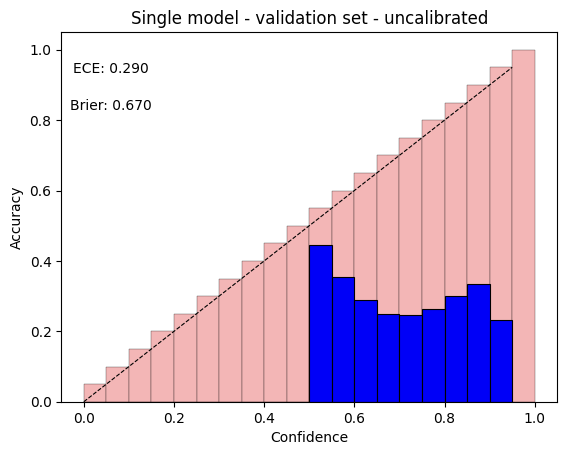

In [6]:
plt.figure()
val_df.query('y == 1').prob_1.hist(bins=100, density=True, alpha=0.5, label='cancer')
val_df.query('y == 0').prob_1.hist(bins=100, density=True, alpha=0.5, label='benign')
plt.axvline(0.5, color='k', linestyle='--',)
plt.legend()
plt.title('Single model - validation set - uncalibrated')
plt.xlabel('Probability of cancer')
plt.ylabel('Density')

plt.figure()
test_df.query('y == 1').prob_1.hist(bins=100, density=True, alpha=0.5, label='cancer')
test_df.query('y == 0').prob_1.hist(bins=100, density=True, alpha=0.5, label='benign')
plt.axvline(0.5, color='k', linestyle='--',)
plt.legend()
plt.title('Single model - test set - uncalibrated')
plt.xlabel('Probability of cancer')
plt.ylabel('Density')

show_reliability_diagram(val_df)
plt.title('Single model - validation set - uncalibrated')
show_reliability_diagram(test_df)
plt.title('Single model - test set - uncalibrated')

In [7]:
from torch.nn.functional import binary_cross_entropy

def calibrate(prob, y, mode='brier', lr=1e-2, max_iter=10000):
    import numpy as np 

    raw_logits = torch.log(prob / (1 - prob))
    target = torch.tensor(y, dtype=torch.float32).view(-1, 1)

    temp = torch.nn.Parameter(
        torch.tensor(1.0, requires_grad=True)
    )

    bias = torch.nn.Parameter(
        torch.tensor(0.0, requires_grad=True)
    )
    # from torch.nn.functional import binary_cross_entropy_with_logits
    optimizer = torch.optim.LBFGS([temp, bias], lr=lr, max_iter=max_iter)

    def closure():
        optimizer.zero_grad()
        output = raw_logits / temp
        output = output + bias
        output = torch.sigmoid(output)

        ind_cancer = target == 1
        ind_normal = target == 0
        
        if mode == 'brier': 
            loss = (output - target).pow(2)
            loss[ind_cancer] *= ind_normal.sum() / ind_cancer.sum()

        elif mode == 'ce':
            loss = binary_cross_entropy(output, target, reduction='none')
            loss[ind_cancer] *= ind_normal.sum() / ind_cancer.sum()

        loss = loss.mean()

        loss.backward()
        return loss

    loss_init = closure()
    optimizer.step(closure)

    # check that loss is decreasing
    loss_final = closure()

    if loss_final > loss_init:
        print(f'Loss increased from {loss_init} to {loss_final}')
        print(f'Using initial values')
        temp.data = 1.0
        bias.data = 0.0

    return temp.data, bias.data

def adjust_probs(probs, temp, bias):
    logits = (torch.log(probs) - torch.log(1 - probs)) / temp + bias
    probs = torch.sigmoid(logits)
    return probs


In [8]:
# Apply calibration 

probs = torch.tensor(val_df.prob_1.values, dtype=torch.float32).view(-1, 1)

#from trusnet.utils.calibration import temp_bias_calibration
temp, bias = calibrate(probs, val_df.y, mode='brier', lr=1e-2, max_iter=10000)
print(temp, bias)
#temp, bias = binary_temp_bias_calibration(probs, val_df.y, mode='brier', lr=1e-3)
#print(temp, bias)

# adjust the probabilities for the validation set and test set 
val_probs = torch.tensor(val_df.prob_1.values, dtype=torch.float32).view(-1, 1)
val_df['prob_1'] = adjust_probs(val_probs, temp, bias).numpy()

test_probs = torch.tensor(test_df.prob_1.values, dtype=torch.float32).view(-1, 1)
test_df['prob_1'] = adjust_probs(test_probs, temp, bias).numpy()
temp, bias

tensor(1.4857) tensor(-0.2424)


(tensor(1.4857), tensor(-0.2424))

Text(0.5, 1.0, 'Single model - test set - calibrated')

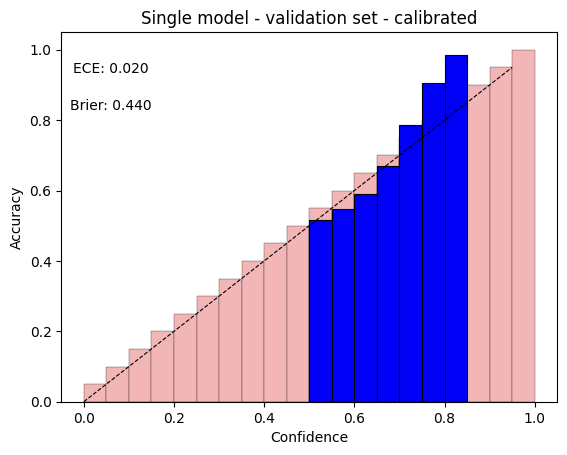

In [9]:

plt.figure()
val_df.query('y == 1').prob_1.hist(bins=100, density=True, alpha=0.5, label='cancer')
val_df.query('y == 0').prob_1.hist(bins=100, density=True, alpha=0.5, label='benign')
plt.axvline(0.5, color='k', linestyle='--',)
plt.legend()
plt.title('Single model - validation set - calibrated')
plt.xlabel('Probability of cancer')
plt.ylabel('Density')

plt.figure()
test_df.query('y == 1').prob_1.hist(bins=100, density=True, alpha=0.5, label='cancer')
test_df.query('y == 0').prob_1.hist(bins=100, density=True, alpha=0.5, label='benign')
plt.axvline(0.5, color='k', linestyle='--',)
plt.legend()
plt.title('Single model - test set - calibrated')
plt.xlabel('Probability of cancer')
plt.ylabel('Density')

show_reliability_diagram(val_df)
plt.title('Single model - validation set - calibrated')
show_reliability_diagram(test_df)
plt.title('Single model - test set - calibrated')



In [10]:
def accuracy_vs_confidence(preds, conf, target, ax=None, label=None):
    ax = ax or plt.gca()

    x = np.linspace(0.5, 1, 100)
    accs = np.zeros_like(x)
    fraction_predicted = np.zeros_like(x)

    for i in range(len(x)):
        t = x[i]
        ind = conf >= t 
        accs[i] = (preds[ind] == target[ind]).mean()
        fraction_predicted[i] = ind.mean()

    #plt.plot(x, accs, label='Accuracy')
    #plt.plot(x, fraction_predicted, label='Fraction predicted')
    plt.plot(fraction_predicted, accs, label=label)

    plt.xlabel('Fraction of data')

    plt.legend()


def accuracy_vs_confidence_quantiles(preds, conf, target, label=None):
    x = np.linspace(0, 1, 100)
    accs = np.zeros_like(x)

    for i in range(len(x)):
        t = np.quantile(conf, x[i])
        ind = conf >= t
        accs[i] = (preds[ind] == target[ind]).mean()

    plt.plot(x, accs, label=label)
    plt.xlabel('Confidence quantile')



def show_acc_vs_confidence(df, ax=None, label=None):
    preds = df.prob_1.values >= 0.5
    conf = np.max(np.stack([df.prob_1.values, 1 - df.prob_1.values], axis=1), axis=1)
    target = df.y.values

    accuracy_vs_confidence(preds, conf, target, ax=ax, label=label)


plt.figure()
show_acc_vs_confidence(val_df, label='Validation set')
show_acc_vs_confidence(test_df, label='Test set')
plt.title('Accuracy vs confidence - single model')




/tmp/ipykernel_10170/1980977162.py:11: RuntimeWarning: Mean of empty slice.
  accs[i] = (preds[ind] == target[ind]).mean()
/h/pwilson/anaconda3/envs/trusnet/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 1.0, 'Accuracy vs confidence - single model')

## Testing ensemble

In [11]:
def make_path(seed, fold, split): 
    return f'/h/pwilson/projects/TRUSnet/projects/IJCARS_2023/outputs/ensemble_fold={fold}_seed={seed}/2023-04-03_15-43-09/epoch_15/{split}.csv'

val_paths = [
    make_path(seed=0, fold=0, split='val') for seed in range(8)
]

test_paths = [
    make_path(seed=0, fold=0, split='test') for seed in range(8)
]



In [12]:
val_df_list = [pd.read_csv(path, index_col=0) for path in val_paths]
test_df_list = [pd.read_csv(path, index_col=0) for path in test_paths]

Text(0.5, 1.0, 'Ensemble - test set - uncalibrated')

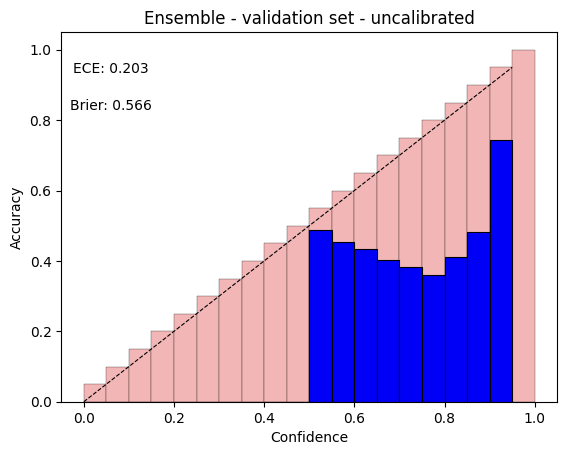

In [13]:
def extract_ensemble_probs(df_list): 

    all_probs = []
    _test_idx = None
    for val_df in df_list:
        if _test_idx is None:
            _test_idx = val_df[['core_specifier', 'position_0', 'position_1']]
        else:
            assert (_test_idx == val_df[['core_specifier', 'position_0', 'position_1']]).all().all()

        all_probs.append(val_df.prob_1.values)

    all_probs = np.stack(all_probs, axis=1)
    probs = all_probs.mean(axis=1)

    return probs

val_probs = extract_ensemble_probs(val_df_list)
test_probs = extract_ensemble_probs(test_df_list)

val_df_ensemble = val_df_list[0].copy()
val_df_ensemble['prob_1'] = val_probs

test_df_ensemble = test_df_list[0].copy()
test_df_ensemble['prob_1'] = test_probs


plt.figure()
val_df_ensemble.query('y == 1').prob_1.hist(bins=100, density=True, alpha=0.5, label='cancer')
val_df_ensemble.query('y == 0').prob_1.hist(bins=100, density=True, alpha=0.5, label='benign')
plt.axvline(0.5, color='k', linestyle='--',)
plt.legend()
plt.title('Ensemble - validation set - uncalibrated')
plt.xlabel('Probability of cancer')
plt.ylabel('Density')

plt.figure()
test_df_ensemble.query('y == 1').prob_1.hist(bins=100, density=True, alpha=0.5, label='cancer')
test_df_ensemble.query('y == 0').prob_1.hist(bins=100, density=True, alpha=0.5, label='benign')
plt.axvline(0.5, color='k', linestyle='--',)
plt.legend()
plt.title('Ensemble - test set - uncalibrated')
plt.xlabel('Probability of cancer')
plt.ylabel('Density')

show_reliability_diagram(val_df_ensemble)
plt.title('Ensemble - validation set - uncalibrated')
show_reliability_diagram(test_df_ensemble)
plt.title('Ensemble - test set - uncalibrated')


In [14]:
targets = val_df_ensemble.y.values

temp, bias = calibrate(torch.tensor(val_df_ensemble.prob_1.values, dtype=torch.float32).view(-1, 1), val_df_ensemble.y, lr=1)

# adjust the probabilities
def adjust_probs(probs, temp, bias):
    logits = (torch.log(probs) - torch.log(1 - probs)) / temp + bias
    probs = torch.sigmoid(logits)
    return probs

val_probs = adjust_probs(torch.tensor(val_df_ensemble.prob_1.values, dtype=torch.float32), temp, bias).detach().numpy()
test_probs = adjust_probs(torch.tensor(test_df_ensemble.prob_1.values, dtype=torch.float32), temp, bias).detach().numpy()

val_df_ensemble['prob_1'] = val_probs
test_df_ensemble['prob_1'] = test_probs


In [15]:
temp, bias

(tensor(1.8619), tensor(-0.1495))

Text(0, 0.5, 'Density')

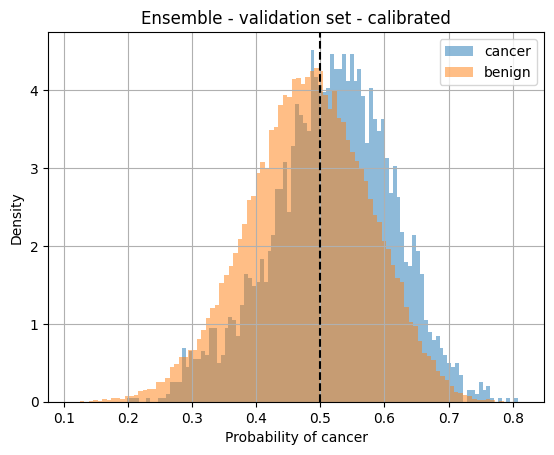

In [16]:

plt.figure()
val_df_ensemble.query('y == 1').prob_1.hist(bins=100, density=True, alpha=0.5, label='cancer')
val_df_ensemble.query('y == 0').prob_1.hist(bins=100, density=True, alpha=0.5, label='benign')
plt.axvline(0.5, color='k', linestyle='--',)
plt.legend()
plt.title('Ensemble - validation set - calibrated')
plt.xlabel('Probability of cancer')
plt.ylabel('Density')

plt.figure()
test_df_ensemble.query('y == 1').prob_1.hist(bins=100, density=True, alpha=0.5, label='cancer')
test_df_ensemble.query('y == 0').prob_1.hist(bins=100, density=True, alpha=0.5, label='benign')
plt.axvline(0.5, color='k', linestyle='--',)
plt.legend()
plt.title('Ensemble - test set - calibrated')
plt.xlabel('Probability of cancer')
plt.ylabel('Density')


In [17]:

show_reliability_diagram(val_df_ensemble)
plt.title('Ensemble - validation set - calibrated')
show_reliability_diagram(test_df_ensemble)
plt.title('Ensemble - test set - calibrated')



Text(0.5, 1.0, 'Ensemble - test set - calibrated')

/tmp/ipykernel_10170/1980977162.py:11: RuntimeWarning: Mean of empty slice.
  accs[i] = (preds[ind] == target[ind]).mean()
/h/pwilson/anaconda3/envs/trusnet/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 1.0, 'Accuracy vs confidence - ensemble')

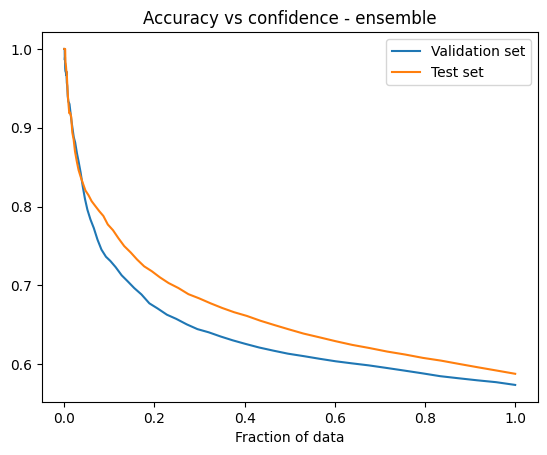

In [18]:
show_acc_vs_confidence(val_df_ensemble, label='Validation set')
show_acc_vs_confidence(test_df_ensemble, label='Test set')
plt.title('Accuracy vs confidence - ensemble')

In [19]:
plt.figure()
show_acc_vs_confidence(test_df_ensemble, label='Ensemble')
show_acc_vs_confidence(test_df, label='Single model')
plt.title('Accuracy vs confidence - ensemble vs single model')

/tmp/ipykernel_10170/1980977162.py:11: RuntimeWarning: Mean of empty slice.
  accs[i] = (preds[ind] == target[ind]).mean()


Text(0.5, 1.0, 'Accuracy vs confidence - ensemble vs single model')

In [21]:
def corewise(df):
    corewise_df = df.groupby(['core_specifier']).prob_1.mean().reset_index()
    corewise_df['y'] = df.groupby(['core_specifier']).y.first().reset_index().y.astype(int)
    return corewise_df

val_df_corewise = corewise(val_df)
# temp, bias = calibrate(torch.tensor(val_df_corewise.prob_1.values, dtype=torch.float32).view(-1, 1), val_df_corewise.y)
# 
# val_df_corewise['prob_1'] = adjust_probs(torch.tensor(val_df_corewise.prob_1.values, dtype=torch.float32), temp, bias).detach().numpy()
# 
# val_df_corewise.prob_1.hist(bins=100, density=True, alpha=0.5, label='cancer')

temp, bias = calibrate(torch.tensor(val_df_corewise.prob_1.values, dtype=torch.float32).view(-1, 1), val_df_corewise.y, mode='ce', lr=1e-3)
print(temp, bias)

val_df_corewise['prob_1'] = adjust_probs(torch.tensor(val_df_corewise.prob_1.values, dtype=torch.float32), temp, bias).detach().numpy()

test_df_corewise = corewise(test_df)
test_df_corewise['prob_1'] = adjust_probs(torch.tensor(test_df_corewise.prob_1.values, dtype=torch.float32), temp, bias).detach().numpy()

tensor(0.3447) tensor(-0.0180)


In [ ]:
test_df_corewise.query('y == 1').prob_1.hist(bins=100, density=True, alpha=0.5, label='cancer')
test_df_corewise.query('y == 0').prob_1.hist(bins=100, density=True, alpha=0.5, label='benign')

plt.text(0.8, 0.9, f'auroc: {roc_auc_score(test_df_corewise.y, test_df_corewise.prob_1):.3f}', transform=plt.gca().transAxes)
plt.text(0.8, 0.8, f'accuracy: {accuracy_score(test_df_corewise.y, test_df_corewise.prob_1 > 0.5):.3f}', transform=plt.gca().transAxes)
plt.legend()
plt.title('Corewise - test set - calibrated - single model')

Text(0.5, 1.0, 'Corewise - test set - calibrated - single model')

In [23]:
# same thing for the ensemble
from sklearn.metrics import roc_auc_score, accuracy_score

val_df_ensemble_corewise = corewise(val_df_ensemble)
test_df_ensemble_corewise = corewise(test_df_ensemble)

temp, bias = calibrate(torch.tensor(val_df_ensemble_corewise.prob_1.values, dtype=torch.float32).view(-1, 1), val_df_ensemble_corewise.y, mode='ce', lr=1e-3)
temp, bias

val_df_ensemble_corewise['prob_1'] = adjust_probs(torch.tensor(val_df_ensemble_corewise.prob_1.values, dtype=torch.float32), temp, bias).detach().numpy()
test_df_ensemble_corewise['prob_1'] = adjust_probs(torch.tensor(test_df_ensemble_corewise.prob_1.values, dtype=torch.float32), temp, bias).detach().numpy()

test_df_ensemble_corewise.query('y == 1').prob_1.hist(bins=100, density=True, alpha=0.5, label='cancer')
test_df_ensemble_corewise.query('y == 0').prob_1.hist(bins=100, density=True, alpha=0.5, label='benign')
plt.text(0.1, 0.9, f'auroc: {roc_auc_score(test_df_ensemble_corewise.y, test_df_ensemble_corewise.prob_1):.3f}', transform=plt.gca().transAxes)
plt.text(0.1, 0.8, f'accuracy: {accuracy_score(test_df_ensemble_corewise.y, test_df_ensemble_corewise.prob_1 > 0.5):.3f}', transform=plt.gca().transAxes)

Text(0.1, 0.8, 'accuracy: 0.645')

In [ ]:
val_df_corewise.query('y == 1').prob_1.hist(bins=100, density=True, alpha=0.5, label='cancer')
val_df_corewise.query('y == 0').prob_1.hist(bins=100, density=True, alpha=0.5, label='benign')

<Axes: >

In [ ]:
from sklearn.metrics import roc_auc_score, recall_score
sens = recall_score(test_df_corewise.y, test_df_corewise.prob_1 > 0.5)
sens
spec = recall_score(1 - test_df_corewise.y, 1 - (test_df_corewise.prob_1 > 0.5))
print(f'Single model, {spec=}, {sens=}')

sens = recall_score(test_df_ensemble_corewise.y, test_df_ensemble_corewise.prob_1 > 0.5)
sens
spec = recall_score(1 - test_df_ensemble_corewise.y, 1 - (test_df_ensemble_corewise.prob_1 > 0.5))
print(f'Ensemble, {spec=}, {sens=}')


Single model, spec=0.621172353455818, sens=0.8278688524590164
Ensemble, spec=0.6307961504811899, sens=0.7786885245901639


Text(0.5, 1.0, 'Corewise - test set - calibrated - ensemble')

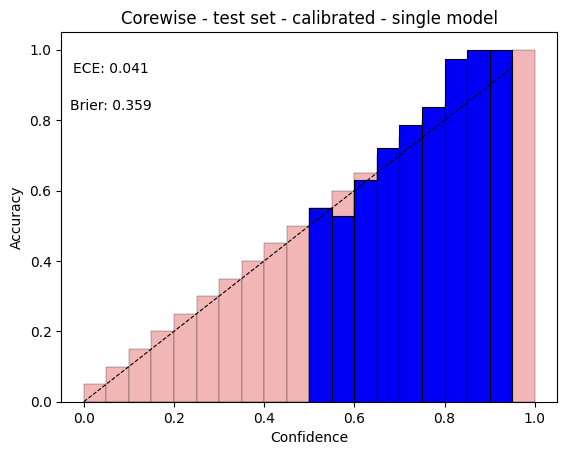

In [ ]:
show_reliability_diagram(test_df_corewise)
plt.title('Corewise - test set - calibrated - single model')

show_reliability_diagram(test_df_ensemble_corewise)
plt.title('Corewise - test set - calibrated - ensemble')


/tmp/ipykernel_13643/3065353683.py:11: RuntimeWarning: Mean of empty slice.
  accs[i] = (preds[ind] == target[ind]).mean()
/h/pwilson/anaconda3/envs/trusnet/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 1.0, 'Corewise - test set - calibrated')

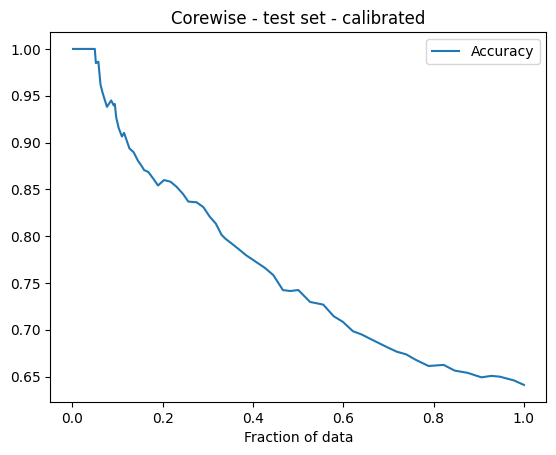

In [ ]:
show_acc_vs_confidence(test_df_corewise)
plt.title('Corewise - test set - calibrated')

In [ ]:
patch_preds = val_df.prob_1.values
patch_labels = val_df.y.values

core_preds = val_df.groupby('core_specifier').prob_1.mean().values
core_labels = val_df.groupby('core_specifier').y.mean().values

from sklearn.metrics import roc_auc_score
print(roc_auc_score(core_labels, core_preds))
print(roc_auc_score(patch_labels, patch_preds))

0.6875084175084175
0.6031316387010601


In [ ]:
patch_preds = test_df.prob_1.values
patch_labels = test_df.y.values

core_preds = test_df.groupby('core_specifier').prob_1.mean().values
core_labels = test_df.groupby('core_specifier').y.mean().values

from sklearn.metrics import roc_auc_score
print(roc_auc_score(core_labels, core_preds))
print(roc_auc_score(patch_labels, patch_preds))

0.8022388594868265
0.6769156668036438


In [ ]:
core_preds

array([0.575906  , 0.49746358, 0.4501693 , ..., 0.50332797, 0.46007338,
       0.49326485], dtype=float32)

0.6875084175084175
0.6031316387010601


In [ ]:
core_labels

array([0., 0., 0., ..., 0., 0., 0.])

(array([2.301e+03, 2.301e+03, 2.259e+03, 2.216e+03, 2.268e+03, 2.226e+03,
        2.246e+03, 2.170e+03, 2.217e+03, 2.098e+03, 2.026e+03, 1.959e+03,
        1.938e+03, 1.926e+03, 1.872e+03, 1.846e+03, 1.704e+03, 1.760e+03,
        1.633e+03, 1.558e+03, 1.458e+03, 1.501e+03, 1.400e+03, 1.352e+03,
        1.274e+03, 1.230e+03, 1.172e+03, 1.162e+03, 1.040e+03, 1.030e+03,
        1.023e+03, 9.320e+02, 8.980e+02, 8.220e+02, 8.230e+02, 7.770e+02,
        7.120e+02, 6.680e+02, 6.290e+02, 5.680e+02, 5.640e+02, 5.510e+02,
        5.100e+02, 4.530e+02, 4.590e+02, 4.180e+02, 3.930e+02, 3.630e+02,
        3.570e+02, 3.140e+02, 2.950e+02, 3.080e+02, 2.970e+02, 2.820e+02,
        2.340e+02, 2.170e+02, 2.010e+02, 2.200e+02, 1.870e+02, 1.620e+02,
        1.390e+02, 1.340e+02, 1.260e+02, 1.540e+02, 1.110e+02, 1.020e+02,
        1.080e+02, 8.900e+01, 8.800e+01, 8.100e+01, 7.200e+01, 7.900e+01,
        6.900e+01, 6.000e+01, 4.100e+01, 3.800e+01, 4.100e+01, 3.600e+01,
        4.600e+01, 2.700e+01, 2.200e+0

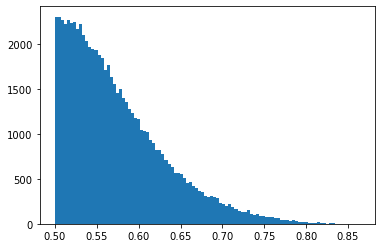

In [ ]:
plt.hist(conf, bins=100)

In [ ]:
conf

array([0.5483445 , 0.5816391 , 0.62204874, ..., 0.5786247 , 0.5389108 ,
       0.56715995], dtype=float32)

In [ ]:
val_df_ensemble.prob_1

0        0.470620
1        0.463772
2        0.443849
3        0.499435
4        0.392791
           ...   
57745    0.346052
57746    0.361575
57747    0.316819
57748    0.371342
57749    0.380129
Name: prob_1, Length: 57750, dtype: float32

,loss,y,prob_0,prob_1,patient_id,path_on_server,center,loc,grade,age,...,secondary_grade,patient_specifier,core_specifier,position_0,position_1,position_2,position_3,needle_intersection,prostate_intersection,confidence
0,0.723803,0,0.484905,0.515096,28,/med-i_data/Data/Exact_Ultrasound/data/full_da...,CRCEO,LBM,Benign,71,...,NaN,CRCEO-0028,CRCEO-0028_LBM,3,8,41,46,0.671297,NaN,0.515096
1,0.698085,0,0.497537,0.502463,28,/med-i_data/Data/Exact_Ultrasound/data/full_da...,CRCEO,LBM,Benign,71,...,NaN,CRCEO-0028,CRCEO-0028_LBM,4,9,39,44,0.623453,NaN,0.502463
2,0.626595,0,0.534408,0.465591,28,/med-i_data/Data/Exact_Ultrasound/data/full_da...,CRCEO,LBM,Benign,71,...,NaN,CRCEO-0028,CRCEO-0028_LBM,4,9,40,45,0.696016,NaN,0.534408
3,0.838611,0,0.432311,0.567689,28,/med-i_data/Data/Exact_Ultrasound/data/full_da...,CRCEO,LBM,Benign,71,...,NaN,CRCEO-0028,CRCEO-0028_LBM,4,9,41,46,0.712646,NaN,0.567689
4,0.465162,0,0.628033,0.371967,28,/med-i_data/Data/Exact_Ultrasound/data/full_da...,CRCEO,LBM,Benign,71,...,NaN,CRCEO-0028,CRCEO-0028_LBM,5,10,38,43,0.661573,NaN,0.628033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57745,1.236055,1,0.709472,0.290528,202,/med-i_data/Data/Exact_Ultrasound/data/full_da...,UVA,RMM,GS9,78,...,5.0,UVA-0202,UVA-0202_RMM,16,21,24,29,0.709377,1.0,0.709472
57746,1.149165,1,0.683099,0.316901,202,/med-i_data/Data/Exact_Ultrasound/data/full_da...,UVA,RMM,GS9,78,...,5.0,UVA-0202,UVA-0202_RMM,16,21,25,30,0.659285,1.0,0.683099
57747,1.413966,1,0.756823,0.243177,202,/med-i_data/Data/Exact_Ultrasound/data/full_da...,UVA,RMM,GS9,78,...,5.0,UVA-0202,UVA-0202_RMM,17,22,22,27,0.676241,1.0,0.756823
57748,1.097014,1,0.666134,0.333866,202,/med-i_data/Data/Exact_Ultrasound/data/full_da...,UVA,RMM,GS9,78,...,5.0,UVA-0202,UVA-0202_RMM,17,22,23,28,0.694014,1.0,0.666134


In [ ]:
all_probs

array([[0.5150955 , 0.5150955 , 0.5150955 , ..., 0.5150955 , 0.5150955 ,
        0.5150955 ],
       [0.5024628 , 0.5024628 , 0.5024628 , ..., 0.5024628 , 0.5024628 ,
        0.5024628 ],
       [0.46559146, 0.46559146, 0.46559146, ..., 0.46559146, 0.46559146,
        0.46559146],
       ...,
       [0.243177  , 0.243177  , 0.243177  , ..., 0.243177  , 0.243177  ,
        0.243177  ],
       [0.3338664 , 0.3338664 , 0.3338664 , ..., 0.3338664 , 0.3338664 ,
        0.3338664 ],
       [0.3493466 , 0.3493466 , 0.3493466 , ..., 0.3493466 , 0.3493466 ,
        0.3493466 ]])

In [ ]:
expected_calibration_error(preds, conf, target, n_bins=20)

(0.04451454508093288,
 {'acc_by_bin': array([0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.50089336, 0.51278402, 0.54767731, 0.62348806,
         0.71905919, 0.86676828, 0.9232    , 1.        , 0.        ]),
  'conf_by_bin': array([0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.52418894, 0.57279265, 0.62190676, 0.67165321,
         0.72099835, 0.7693696 , 0.81688482, 0.86008036, 0.        ]),
  'n_by_bin': array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 2.9667e+04, 2.0858e+04, 1.1182e+04, 5.0930e+03,
         2.0180e+03, 6.6200e+02, 1.0000e+02, 2.0000e+00, 0.0000e+00]),
  'bins': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
         0.55, 0.6 ,

In [ ]:
conf.shape

(69582, 1)

/tmp/ipykernel_3021/1182857513.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  test_df_corewise = test_df.groupby('core_specifier').mean()
/tmp/ipykernel_3021/1182857513.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  val_df_corewise = val_df.groupby('core_specifier').mean()


Text(0.5, 1.0, 'val')

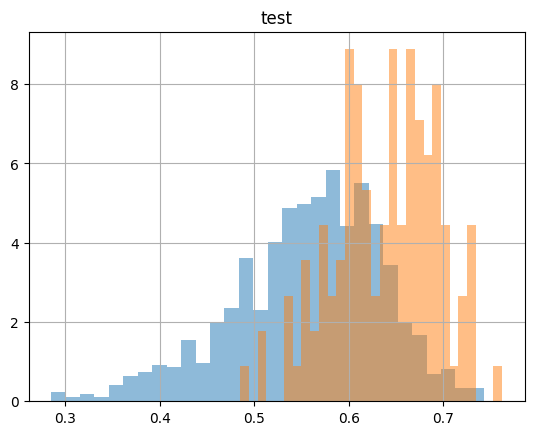

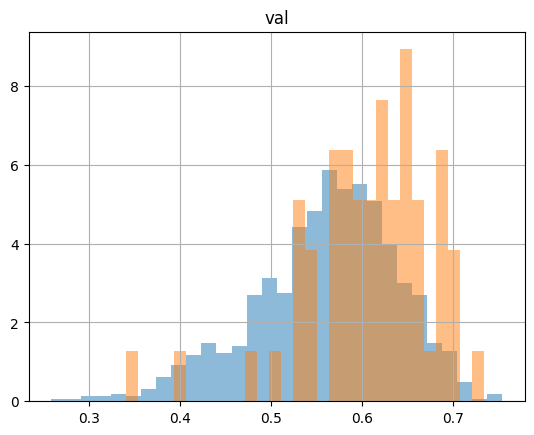

In [ ]:
# go to corewise
test_df_corewise = test_df.groupby('core_specifier').mean()
val_df_corewise = val_df.groupby('core_specifier').mean()

# same thing for test
test_df_corewise.groupby('y').prob_1.hist(bins=30, density=True, alpha=0.5)
plt.title('test')
plt.figure()
val_df_corewise.groupby('y').prob_1.hist(bins=30, density=True, alpha=0.5)
plt.title('val')


In [31]:
#df = df.query("y == 0")

from trusnet.utils.metrics import expected_calibration_error
df = test_df
preds = (df.prob_1.values > 0.50).astype(int)
probs = df.prob_1.values
conf = np.max(np.stack([probs, 1-probs]), axis=0)
y = df.y.values

val, outs = expected_calibration_error(preds, conf, y, n_bins=20)

/h/pwilson/anaconda3/envs/trusnet/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /ssd003/home/pwilson/anaconda3/envs/trusnet/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail19maybe_wrap_dim_slowEllb
  warn(f"Failed to load image Python extension: {e}")


In [ ]:
PATH = '/h/pwilson/projects/TRUSnet/projects/IJCARS_2023/outputs/ensemble_fold=0_seed=0/2023-04-12_15-59-40/epoch_1/test_patchwise.csv'

test_df = pd.read_csv(PATH)


In [ ]:
test_df.prob_1.hist()

In [34]:
PATH = '/h/pwilson/projects/TRUSnet/projects/IJCARS_2023/outputs/ensemble_fold=0_seed=0/2023-04-12_15-59-40/epoch_1/test_patchwise.csv'
test_df = pd.read_csv(PATH)
PATH = '/h/pwilson/projects/TRUSnet/projects/IJCARS_2023/outputs/ensemble_fold=0_seed=0/2023-04-12_15-59-40/epoch_1/val_patchwise.csv'
val_df = pd.read_csv(PATH)


def apply_temperature_calibration(val_df, test_df, lr=1e-2):
    val_probs = torch.tensor(val_df.prob_1.values).view(-1, 1)
    val_y = torch.tensor(val_df.y.values).view(-1, 1)

    from trusnet.utils.calibration import (
        compute_temperature_and_bias_for_calibration,
        apply_temperature_and_bias,
    )

    temp, bias = calibrate(val_probs, val_y, lr=lr, mode='ce')
    print(f"Temperature: {temp:.3f}, bias: {bias:.3f}")

    val_df["prob_1"] = apply_temperature_and_bias(val_df.prob_1.values, temp, bias)
    test_df["prob_1"] = apply_temperature_and_bias(test_df.prob_1.values, temp, bias)

    return val_df, test_df


val_df, test_df = apply_temperature_calibration(val_df, test_df, lr=1)

show_reliability_diagram(test_df)

/tmp/ipykernel_10170/1356296023.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(y, dtype=torch.float32).view(-1, 1)


RuntimeError: Found dtype Float but expected Double